In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("plot_data/no_ellipse_prompts_plots.csv")

In [3]:
data

,Step,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean__MIN,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean__MAX,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean__MIN,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean__MAX
0,20,0.189057,0.175724,0.198584,0.191352,0.174878,0.215706
1,40,0.193545,0.179012,0.208260,0.199519,0.177824,0.215812
2,60,0.189578,0.178239,0.197087,0.194796,0.186035,0.206453
3,80,0.198143,0.176733,0.208276,0.190169,0.172852,0.209440
4,100,0.191466,0.184058,0.196403,0.193932,0.180835,0.208903
...,...,...,...,...,...,...,...
4837,96760,NaN,NaN,NaN,1.000000,1.000000,1.000000
4838,96780,NaN,NaN,NaN,1.000000,1.000000,1.000000
4839,96800,NaN,NaN,NaN,1.000000,1.000000,1.000000
4840,96820,NaN,NaN,NaN,1.000000,1.000000,1.000000


In [4]:
trunc_data = data[data["Step"] <= 80000]

In [5]:
trunc_data.columns = ["Step", "no_ellipse_mean", "no_ellipse_min", "no_ellipse_max", "with_ellipse_mean", "with_ellipse_min", "with_ellipse_max"]

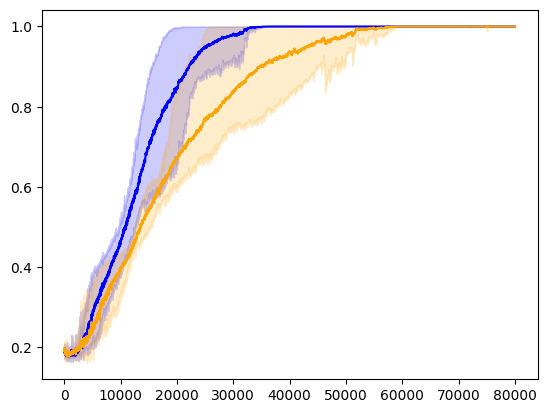

In [6]:
plt.plot(trunc_data["Step"], trunc_data["no_ellipse_mean"], color="blue")
plt.fill_between(trunc_data["Step"], trunc_data["no_ellipse_min"], trunc_data["no_ellipse_max"], color="blue", alpha=0.2, label="Range")

plt.plot(trunc_data["Step"], trunc_data["with_ellipse_mean"], color="orange")
plt.fill_between(trunc_data["Step"], trunc_data["with_ellipse_min"], trunc_data["with_ellipse_max"], color="orange", alpha=0.2, label="Range")

In [7]:
data[data["Step"] == 30000]

,Step,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean__MIN,ddpo_trainer_config.no_ellipse_prompts: true - trained_validation/size_mean__MAX,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean__MIN,ddpo_trainer_config.no_ellipse_prompts: false - trained_validation/size_mean__MAX
1499,30000,0.981675,0.928304,1.0,0.839421,0.755835,0.999878


In [8]:
import wandb


In [9]:
# Connect to your W&B project
api = wandb.Api()

# Replace with your entity/project and group name
entity = "ryanteehan"
project = "stable_diffusion_training"
group = "your-group"


runs = api.runs(f"{entity}/{project}", filters={"group": "sacred-beetle"})
condor_runs = api.runs(f"{entity}/{project}", filters={"group": "striking-condor"})

In [10]:
for run in condor_runs:
    print(run.name)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


striking-condor_no_ellipse_True_seed_140_...
striking-condor_no_ellipse_True_seed_170_...
striking-condor_no_ellipse_False_seed_130_...
striking-condor_no_ellipse_False_seed_160_...
striking-condor_no_ellipse_False_seed_120_...
striking-condor_no_ellipse_False_seed_180_...
striking-condor_no_ellipse_False_seed_140_...
striking-condor_no_ellipse_False_seed_190_...
striking-condor_no_ellipse_False_seed_150_...
striking-condor_no_ellipse_False_seed_170_...


In [11]:
import numpy as np

def wandb_random_sampling(x, y, k=1500, ignore_outliers=False, seed=None):
    x = np.asarray(x); y = np.asarray(y)
    assert x.shape == y.shape
    mask = np.ones(len(y), dtype=bool)
    if ignore_outliers and len(y) >= 20:  # need enough points for quantiles
        lo, hi = np.quantile(y, [0.05, 0.95])
        mask &= (y >= lo) & (y <= hi)

    x_f, y_f = x[mask], y[mask]
    n = len(y_f)
    if n == 0:
        return x_f, y_f

    if n > k:
        rng = np.random.default_rng(seed)
        idx = rng.choice(n, size=k, replace=False)
        x_f, y_f = x_f[idx], y_f[idx]

    order = np.argsort(x_f)
    return x_f[order], y_f[order]


def wandb_random_sample_df(
    df: pd.DataFrame,
    x: str = "step",           # e.g. "step", "_step", "global_step", "_runtime", "_timestamp"
    y: str = "loss",           # metric column
    k: int = 1500,             # max points
    ignore_outliers: bool = False,
    seed: int | None = None,
    keep: list[str] | None = None,  # extra cols to carry along (e.g. "run", "split")
) -> pd.DataFrame:
    cols = [x, y] + (keep or [])
    d = df.loc[:, [c for c in cols if c in df.columns]].dropna(subset=[x, y]).copy()

    if ignore_outliers and len(d) >= 20:
        lo, hi = d[y].quantile([0.05, 0.95])
        d = d[d[y].between(lo, hi)]

    n = len(d)
    if n == 0:
        return d

    if n > k:
        rng = np.random.default_rng(seed)
        take = rng.choice(n, size=k, replace=False)
        d = d.iloc[take]

    return d.sort_values(x).reset_index(drop=True)


In [12]:
# import numpy as np 



# metric = "trained_validation/size_mean"   # replace with your metric name
# dfs = []
# for run in runs:
#     hist = run.history(keys=[metric], pandas=True)
#     if metric in hist:
#         hist = hist[["_step", metric]]
#         dfs.append(hist.reset_index(drop=True))

# # Define anchor grid for x-axis
# max_step = max(df["_step"].max() for df in dfs)
# N = 20000  # number of anchor points
# grid = np.linspace(0, max_step, N)

# def random_sampling_aggregate(run_dfs, metric, grid, n_resamples=20, bin_halfwidth=10):
#     agg_means = []
#     agg_stds = []
#     for _ in range(n_resamples):
#         sampled = []
#         for run_df in run_dfs:
#             vals = []
#             for g in grid:
#                 # find values close to g
#                 window = run_df.loc[(run_df["_step"] >= g - bin_halfwidth) &
#                                     (run_df["_step"] < g + bin_halfwidth), metric]
#                 if not window.empty:
#                     vals.append(window.sample(1).values[0])
#                 else:
#                     vals.append(np.nan)
#             print(sampled)
#             sampled.append(vals)
#         arr = np.array(sampled, dtype=float)
#         agg_means.append(np.nanmean(arr, axis=0))
#         agg_stds.append(np.nanstd(arr, axis=0))
#     return np.mean(agg_means, axis=0), np.mean(agg_stds, axis=0)

# mean, std = random_sampling_aggregate(dfs, metric, grid)
# plt.plot(grid, mean, label="mean")
# plt.fill_between(grid, mean - std, mean + std, alpha=0.3, label="±std")
# plt.xlabel("step")
# plt.ylabel(metric)
# plt.legend()
# plt.show()

# # # Align runs by step (outer join)
# # aligned = pd.concat(dfs, axis=1)

# # # Compute mean/std across runs
# # mean = aligned.mean(axis=1)
# # std = aligned.std(axis=1)

# # # Plot
# # plt.plot(mean["_step"], mean.values, label="mean")
# # plt.fill_between(mean.index, mean - std, mean + std, alpha=0.3, label="±std")

# dfs = []
# for run in condor_runs:
#     hist = run.history(keys=[metric], pandas=True)
#     if metric in hist:
#         hist = hist[[metric]].rename(columns={metric: run.name})
#         dfs.append(hist.reset_index(drop=True))

# # # Align runs by step (outer join)
# # aligned = pd.concat(dfs, axis=1)

# # # Compute mean/std across runs
# # mean = aligned.mean(axis=1)
# # std = aligned.std(axis=1)
# # plt.plot(mean.index, mean.values, label="mean2")
# # plt.fill_between(mean.index, mean - std, mean + std, alpha=0.3, label="±std2")


# # plt.legend()
# # plt.show()


In [27]:
run.history(keys=[metric], pandas=True)

,_step,trained_validation/size_mean
0,180,0.177694
1,240,0.183285
2,340,0.183122
3,500,0.182666
4,880,0.167065
...,...,...
495,90900,1.000000
496,90960,1.000000
497,91060,1.000000
498,91080,1.000000


In [36]:
hist.columns[1]

'sacred-beetle_no_ellipse_seed_22_...'

In [44]:
wandb_random_sample_df(hist, "_step", metric)

,_step,trained_validation/size_mean
0,60,0.197087
1,180,0.201904
2,280,0.176302
3,340,0.180811
4,360,0.196558
...,...,...
495,60780,0.999992
496,61000,1.000000
497,61240,1.000000
498,61680,1.000000


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- per-run random sampling (as before) ---------------------------
def wandb_random_sample_df(
    df: pd.DataFrame,
    x: str = "step",
    y: str = "loss",
    k: int = 1500,
    ignore_outliers: bool = False,
    seed: int | None = None,
) -> pd.DataFrame:
    d = df[[c for c in (x, y) if c in df.columns]].dropna(subset=[x, y]).copy()
    if d.empty:
        return d
    if ignore_outliers and len(d) >= 20:
        lo, hi = d[y].quantile([0.05, 0.95])
        d = d[d[y].between(lo, hi)]
        if d.empty:
            return d
    if len(d) > k:
        rng = np.random.default_rng(seed)
        d = d.iloc[rng.choice(len(d), size=k, replace=False)]
    return (d.sort_values(x)
              .drop_duplicates(subset=[x], keep="last")
              .reset_index(drop=True))

# --- nearest-neighbor projection onto a single grid ----------------
def _nearest_on_grid(xv: np.ndarray, yv: np.ndarray, grid: np.ndarray, max_dx: float | None):
    # xv,yv must be sorted by xv
    idx = np.searchsorted(xv, grid)  # nearest is idx or idx-1
    idx0 = np.clip(idx - 1, 0, len(xv) - 1)
    idx1 = np.clip(idx,       0, len(xv) - 1)
    # choose whichever x is closer
    pick_left  = np.abs(grid - xv[idx0]) <= np.abs(xv[idx1] - grid)
    choose = np.where(pick_left, idx0, idx1)
    yi = yv[choose]
    if max_dx is not None:
        dist = np.abs(xv[choose] - grid)
        yi = np.where(dist <= max_dx, yi, np.nan)
    return yi  # shape (len(grid),)

def aggregate_runs_nearest_grid(
    run_dfs: list[pd.DataFrame],
    x: str = "step",
    y: str = "loss",
    k: int = 1500,
    ignore_outliers: bool = False,
    base_seed: int | None = None,
    grid: np.ndarray | None = None,   # if None, we'll build one (see below)
    grid_points: int = 512,
    grid_mode: str = "linspace",      # "linspace" | "ref_run"
    ref_index: int = 0,               # which run provides grid if grid_mode="ref_run"
    domain: str = "global",           # "global" (min over mins, max over maxes) or "overlap" (max min to min max)
    max_dx: float | None = None,      # exclude nearest picks farther than this (same units as x)
):
    # 1) per-run W&B-style sampling
    sampled = []
    for i, df in enumerate(run_dfs):
        seed = None if base_seed is None else base_seed + i
        d = wandb_random_sample_df(df, x=x, y=y, k=k, ignore_outliers=ignore_outliers, seed=seed)
        if not d.empty:
            d = d[[x, y]].copy()
            d["__run__"] = i
            sampled.append(d)
    if not sampled:
        raise ValueError("No data after sampling.")

    # 2) build a single grid
    if grid is None:
        if grid_mode == "ref_run":
            gsrc = sampled[ref_index].sort_values(x)[x].to_numpy()
            grid = gsrc
        else:
            mins = [s[x].min() for s in sampled]
            maxs = [s[x].max() for s in sampled]
            lo = (max(mins) if domain == "overlap" else min(mins))
            hi = (min(maxs) if domain == "overlap" else max(maxs))
            if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
                # fall back to ref_run grid if overlap collapses
                gsrc = sampled[ref_index].sort_values(x)[x].to_numpy()
                grid = gsrc
            else:
                grid = np.linspace(lo, hi, grid_points)

    # 3) nearest-neighbor pick per run on that grid
    cols = []
    for s in sampled:
        xv = s[x].to_numpy(); yv = s[y].to_numpy()
        order = np.argsort(xv)
        yi = _nearest_on_grid(xv[order], yv[order], grid, max_dx=max_dx)
        cols.append(yi)
    Y = np.vstack(cols).T  # shape = (len(grid), n_runs)

    # 4) aggregate across runs at each grid x
    agg = pd.DataFrame({
        "x": grid,
        "mean": np.nanmean(Y, axis=1),
        "std":  np.nanstd(Y,  axis=1, ddof=1),
        "count": np.sum(~np.isnan(Y), axis=1).astype(int),
    })

    # per-run mapped series on the grid (optional overlay)
    mapped_runs = [
        pd.DataFrame({"x": grid, y: Y[:, j], "__run__": j})
        for j in range(Y.shape[1])
    ]
    return agg, mapped_runs, sampled

# --- plotting -------------------------------------------------------
def plot_mean_with_std_band_nearest(agg: pd.DataFrame, mapped_runs: list[pd.DataFrame], y: str, overlay_runs=False, run_alpha=0.25, color="blue", ax=None, label="mean"):
    if ax is None:
        # plt.figure(facecolor="#d6e8f7")
        fig, ax = plt.subplots()
        fig.patch.set_facecolor("#F7F6F2")
    if overlay_runs:
        for mr in mapped_runs:
            ax.plot(mr["x"], mr[y], alpha=run_alpha, linewidth=1)
    # ax.set_facecolor("#d6e8f7")
    ax.plot(agg["x"], agg["mean"], linewidth=2, label=label, color=color)
    ax.fill_between(agg["x"], agg["mean"] - agg["std"], agg["mean"] + agg["std"], alpha=0.2, linewidth=0, color=color)
    
    ax.legend()
    return ax


In [64]:
# runs is a list[pd.DataFrame], each with columns like "step", "train/loss"
agg, mapped, sampled = aggregate_runs_nearest_grid(
    dfs, x="_step", y=metric,
    k=1500, ignore_outliers=True, base_seed=123,
    grid_mode="ref_run", ref_index=0,      # or grid_mode="linspace", grid_points=800
    domain="overlap",                      # only for linspace mode
    max_dx=None                            # or e.g. max_dx=50 to drop far matches
)


Text(0, 0.5, 'train/loss')

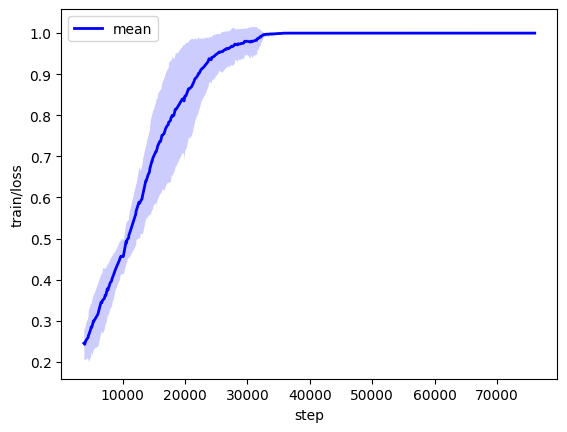

In [73]:
# runs: list[pd.DataFrame] (each has columns x and y)
agg, mapped, sampled = aggregate_runs_nearest_grid(
    dfs, x="_step", y=metric,
    k=1500, ignore_outliers=True, base_seed=123,
    grid_mode="ref_run", ref_index=0,      # or grid_mode="linspace", grid_points=800
    domain="overlap",                      # only for linspace mode
    max_dx=None                            # or e.g. max_dx=50 to drop far matches
)
ax = plot_mean_with_std_band_nearest(agg, mapped, y=metric, overlay_runs=False)
ax.set_xlabel("step"); ax.set_ylabel("train/loss")


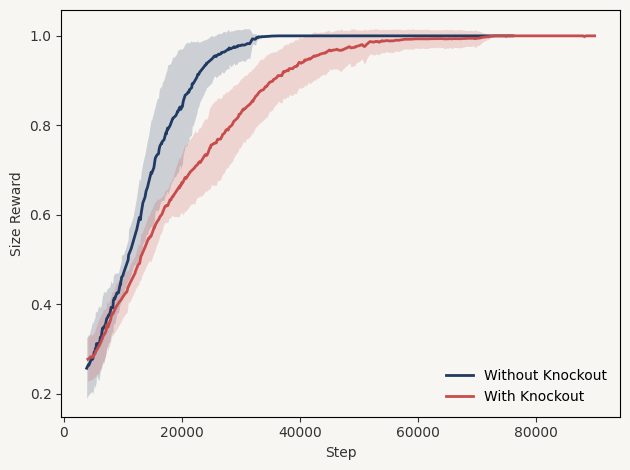

In [101]:
metric = "trained_validation/size_mean"   # replace with your metric name
dfs = []
for run in runs:
    hist = run.history(keys=[metric], pandas=True)
    if metric in hist:
        hist = hist[["_step", metric]]
        dfs.append(hist.reset_index(drop=True))

agg, mapped, sampled = aggregate_runs_nearest_grid(
    dfs, x="_step", y=metric,
    k=1500, ignore_outliers=True, base_seed=123,
    grid_mode="ref_run", ref_index=0,      # or grid_mode="linspace", grid_points=800
    domain="overlap",                      # only for linspace mode
    max_dx=None                            # or e.g. max_dx=50 to drop far matches
)

offwhite = "#F7F6F2"
ax = plot_mean_with_std_band_nearest(agg, mapped, y=metric, overlay_runs=False, color="#203A63", label="Without Knockout")
ax.set_xlabel("step"); ax.set_ylabel("train/loss")


metric = "trained_validation/size_mean"   # replace with your metric name
dfs = []
for run in condor_runs:
    hist = run.history(keys=[metric], pandas=True)
    if metric in hist:
        hist = hist[["_step", metric]]
        dfs.append(hist.reset_index(drop=True))

agg, mapped, sampled = aggregate_runs_nearest_grid(
    dfs, x="_step", y=metric,
    k=1500, ignore_outliers=True, base_seed=123,
    grid_mode="ref_run", ref_index=0,      # or grid_mode="linspace", grid_points=800
    domain="overlap",                      # only for linspace mode
    max_dx=None                            # or e.g. max_dx=50 to drop far matches
)


ax = plot_mean_with_std_band_nearest(agg, mapped, y=metric, overlay_runs=False, color="#C94C4C", ax=ax, label="With Knockout")
ax.set_facecolor(offwhite)
ax.tick_params(colors="#333333")
ax.xaxis.label.set_color("#333333")
ax.yaxis.label.set_color("#333333")
ax.set_xlabel("Step"); ax.set_ylabel("Size Reward")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("agg_reward_plot_dsprites.png", facecolor=offwhite, bbox_inches="tight", dpi=300)
plt.show()

